# Project 4 - Advanced Lane Line - Minsu Kang

## Camera Calibration

### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.



Read images and output them here

In [41]:
%matplotlib inline
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob

In [51]:
def plot_figures(figures, nrows = 1, ncols=1):
    if type(figures) is list:
        figures = dict(zip(range(len(figures)), figures))
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows)
    for ind,title in zip(range(len(figures)), figures):
        axeslist.ravel()[ind].imshow(figures[title], cmap=plt.gray())
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    #plt.tight_layout() # optional

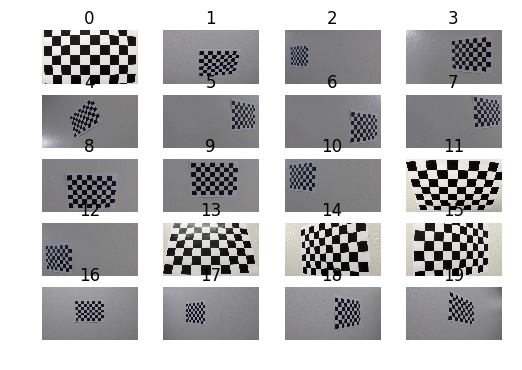

In [72]:
calibration_dir = 'camera_cal'
image_names = glob.glob('camera_cal/calibration*.jpg')
images = [mpimg.imread(image_path) for image_path in image_names]
#image_dict = dict(zip(range(len(images)), images))
plot_figures(images,5,4)
plt.show()

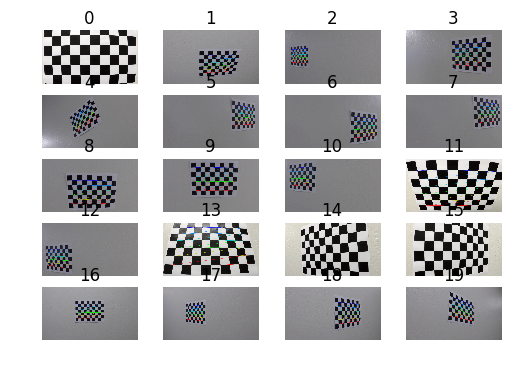

In [135]:
objpoints = [] #(0,0,0) -> (8,5,0)
imgpoints = []
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

for img in images:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plot_figures(images,5,4)

In [75]:
img_size = (images[0].shape[1], images[0].shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [83]:
def undistort_image(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [148]:
img_path = os.path.join(calibration_dir,'calibration1.jpg')
img = cv2.imread(img_path)
dst = undistort_image(img)
cv2.imwrite(os.path.join(calibration_dir,'calibration1_undistort.jpg'),dst)

True

### perspective transform

(720, 1280, 3)


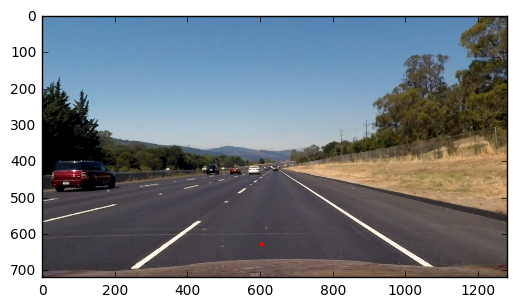

In [114]:
%matplotlib inline
import matplotlib.patches as patches
from matplotlib.widgets import Slider

img = mpimg.imread('test_images/straight_lines1.jpg')


def image_point_show(x, y):
    fig,ax = plt.subplots(1)
    # Create a Rectangle patch
    rect = patches.Rectangle((x,y),5,5,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.imshow(img)
    # plt.show()

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
interact(image_point_show, x=widgets.IntSlider(min=0,max=img.shape[1],step=10,value=10),y=widgets.IntSlider(min=0,max=img.shape[0],step=10,value=10));

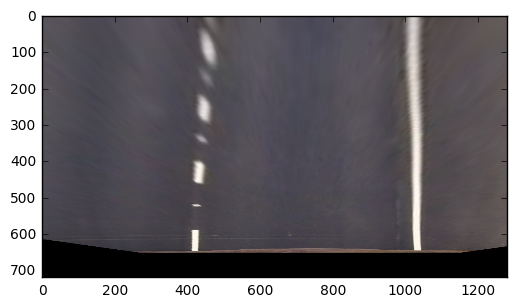

In [304]:
src = np.array([[330,625],[965,625],[550,475],[730,475]], np.float32)
dst = np.array([[400,625],[1035,625],[400,400],[1035,400]], np.float32)
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img = mpimg.imread('test_images/straight_lines2.jpg')
img = undistort_image(img)
def perspective_transform(image):
    warped = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

im = perspective_transform(img) 
plt.imshow(im)

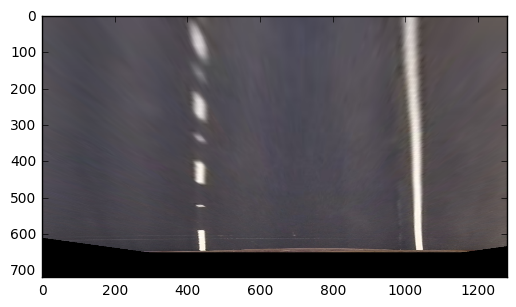

In [279]:
def generate_parallel(a,b,c,d):
    src = np.array([[a,625],[b,625],[c,475],[d,475]], np.float32) #a=330,b=965,c=550,d=730
    dst = np.array([[400,625],[1035,625],[400,400],[1035,400]], np.float32)
    img = mpimg.imread('test_images/straight_lines2.jpg')
    img = undistort_image(img)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    plt.imshow(warped)

interact(generate_parallel, 
         a=widgets.IntSlider(min=300,max=400,step=5,value=310),
         b=widgets.IntSlider(min=930,max=1030,step=5,value=960),
         c=widgets.IntSlider(min=500,max=600,step=5,value=550),
         d=widgets.IntSlider(min=680,max=780,step=5,value=730),);

In [280]:
def show_two_images(image1, image2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(image2)
    ax2.set_title('Transformed Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()

In [195]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    abs_sobel = abs_sobel_at_orient(image, orient, sobel_kernel)
    scaled_sobel = np.uint8(abs_sobel * 255 / np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    sobelx = abs_sobel_at_orient(image, 'x', sobel_kernel)
    sobely = abs_sobel_at_orient(image, 'y', sobel_kernel)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    mag_binary = np.zeros_like(magnitude)
    mag_binary[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1
    return mag_binary


def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    sobelx = abs_sobel_at_orient(image, 'x', sobel_kernel)
    sobely = abs_sobel_at_orient(image, 'y', sobel_kernel)
    direction = np.arctan2(sobely, sobelx)
    dir_binary = np.zeros_like(sobelx)
    dir_binary[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return dir_binary


def abs_sobel_at_orient(image, orient='x', sobel_kernel=3):
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return np.absolute(sobel)

def hls_thresh(image, thresh=(0, 255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary
    


In [406]:
def sobel_image(image):
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(110, 205))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=3, thresh=(70, 200))
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(40, 250))
    dir_binary = dir_threshold(image, sobel_kernel=3, thresh=(0.8, 1.5))

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined
    

call
here
now


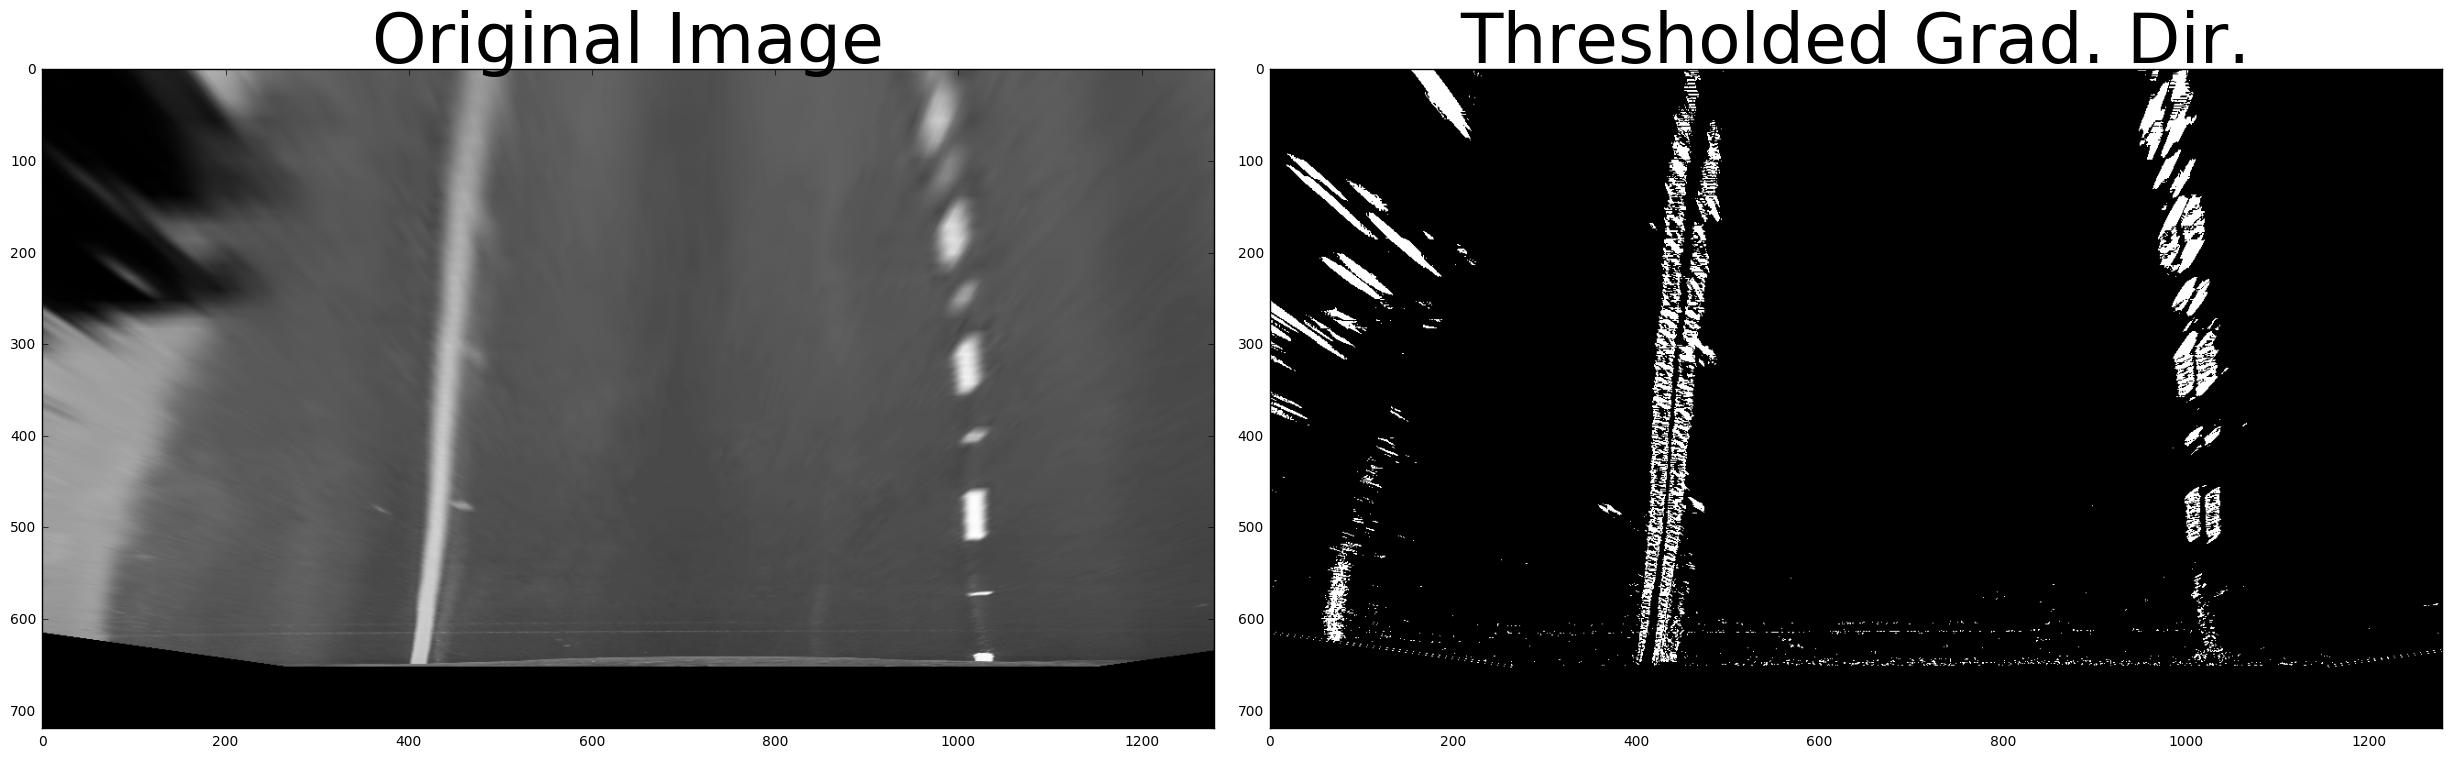

In [249]:
k_img = mpimg.imread('test_images/straight_lines1.jpg')
k_img = undistort_image(k_img)
k_img = perspective_transform(k_img)
k_img = cv2.cvtColor(k_img, cv2.COLOR_RGB2GRAY)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(k_img, orient='x', sobel_kernel=ksize, thresh=(150, 205))
grady = abs_sobel_thresh(k_img, orient='y', sobel_kernel=ksize, thresh=(110, 200))
mag_binary = mag_thresh(k_img, sobel_kernel=ksize, mag_thresh=(20, 250))
dir_binary = dir_threshold(k_img, sobel_kernel=ksize, thresh=(0.1, 1.2))

combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(k_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()



In [403]:
test_img = mpimg.imread('test_images/test4.jpg')
test_img = undistort_image(test_img)
#test_img = perspective_transform(test_img)

def sobel_threshold_on_image(k_size, x_low, x_high, y_low, y_high, mag_low, mag_high, dir_low, dir_high, hls_low, hls_high):
    #image = cv2.cvtColor(test_img,cv2.COLOR_RGB2GRAY)
    image = test_img
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=k_size, thresh=(x_low, x_high))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=k_size, thresh=(y_low, y_high))
    mag_binary = mag_thresh(image, sobel_kernel=k_size, mag_thresh=(mag_low, mag_high))
    dir_binary = dir_threshold(image, sobel_kernel=k_size, thresh=(dir_low, dir_high))
    hls_binary = hls_thresh(test_img,thresh=(hls_low,hls_high))
    #hls_binary_extend = np.rollaxis(np.array([hls_binary,hls_binary,hls_binary]),0,3)
    
    combined = np.zeros_like(dir_binary)
    combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)))] = 1
    combined = perspective_transform(combined)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(combined)
    ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()



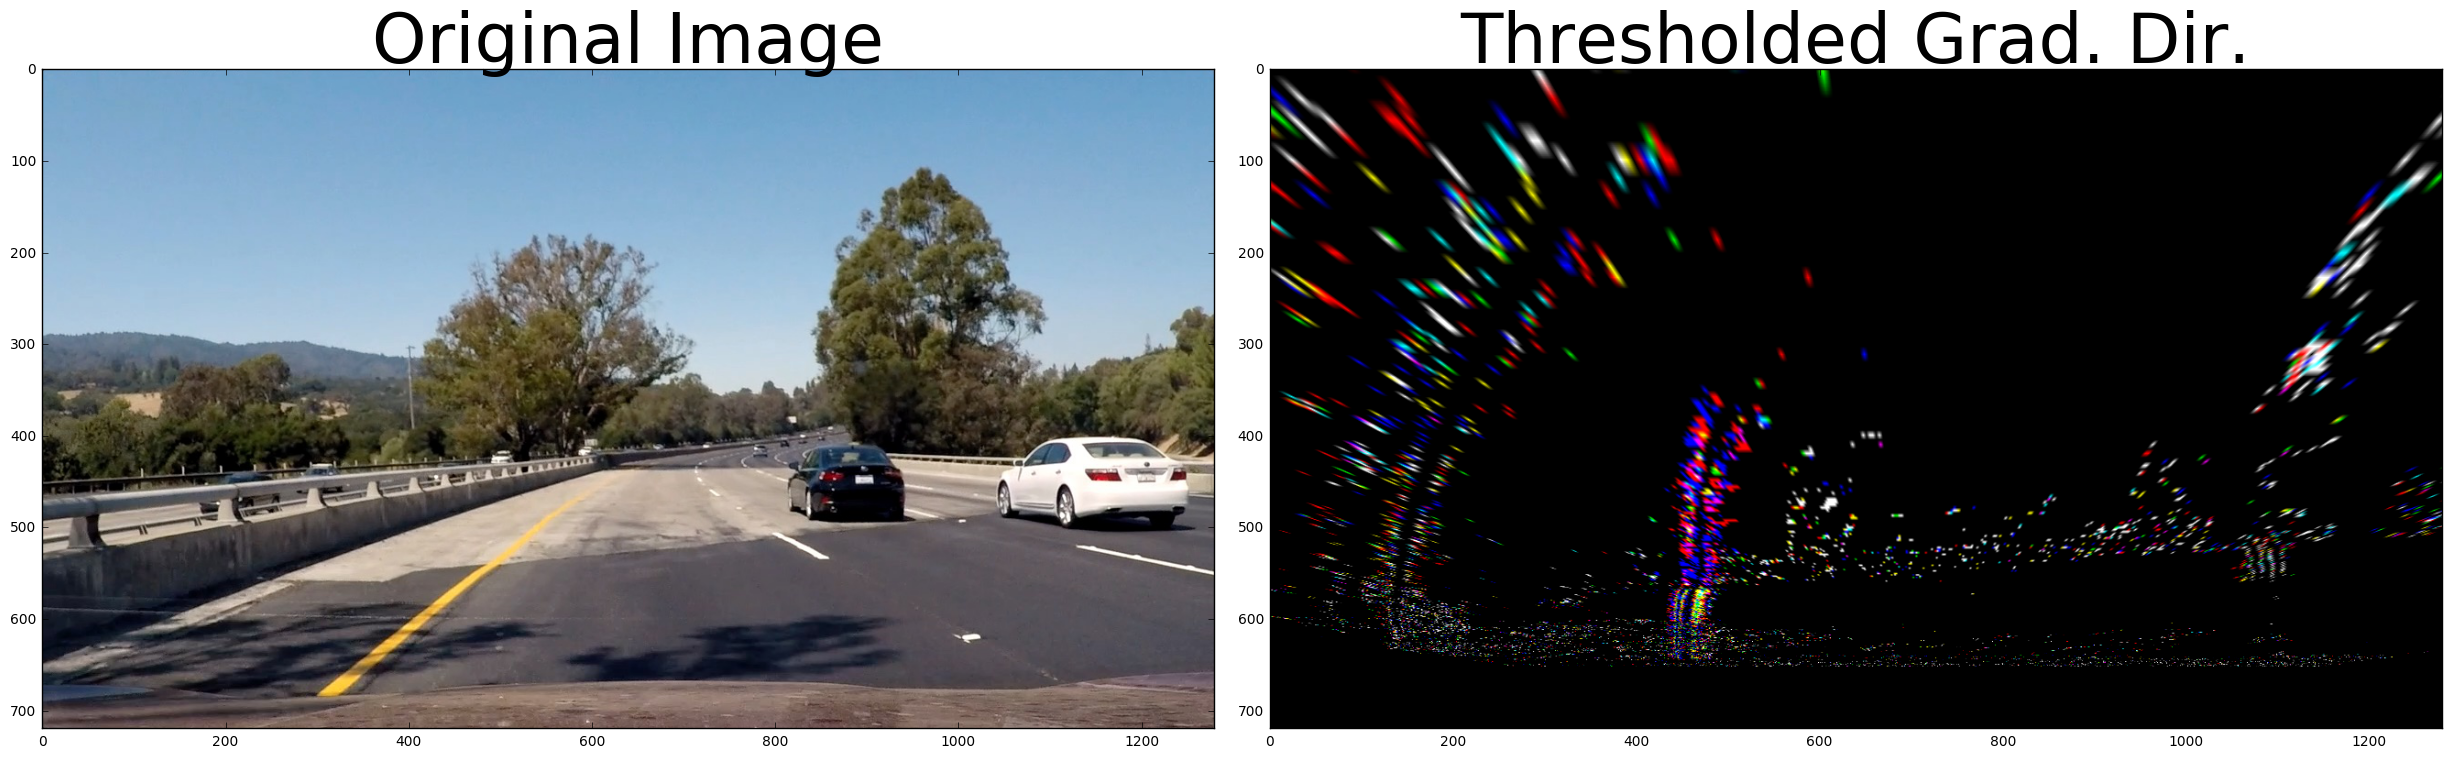

In [404]:


interact(sobel_threshold_on_image,
         k_size=widgets.IntSlider(min=3,max=9,step=2,value=3),
         x_low=widgets.IntSlider(min=0,max=255,step=5,value=150), x_high=widgets.IntSlider(min=0,max=255,step=5,value=255),
         y_low=widgets.IntSlider(min=0,max=255,step=5,value=70), y_high=widgets.IntSlider(min=0,max=255,step=5,value=200),
         mag_low=widgets.IntSlider(min=0,max=255,step=5,value=70), mag_high=widgets.IntSlider(min=0,max=255,step=5,value=250),
         dir_low=widgets.FloatSlider(min=0.0,max=3.2,step=0.1,value=0.1),dir_high=widgets.FloatSlider(min=0.0,max=3.2,step=0.1,value=1.5),
         hls_low=widgets.IntSlider(min=0,max=255,step=5,value=0), hls_high=widgets.IntSlider(min=0,max=255,step=5,value=250),
        );

In [397]:
k_size = 3
t_img = mpimg.imread('test_images/test4.jpg')
t_img = undistort_image(t_img)
t_img = perspective_transform(t_img)

def hls_sobel_combination(mag_low, mag_high, dir_low, dir_high, hls_low, hls_high):
    gray = cv2.cvtColor(t_img, cv2.COLOR_RGB2GRAY)
    hls = cv2.cvtColor(t_img, cv2.COLOR_RGB2HLS)
    mag_binary = mag_thresh(gray, sobel_kernel=k_size, mag_thresh=(mag_low, mag_high))
    dir_binary = dir_threshold(gray, sobel_kernel=k_size, thresh=(dir_low, dir_high))
    hls_binary = hls_thresh(hls,thresh=(hls_low,hls_high))
    combined = np.zeros_like(dir_binary)
    combined[(((mag_binary == 1) & (dir_binary == 1) & (hls_binary == 1)))] = 1
    show_two_images(t_img, combined)

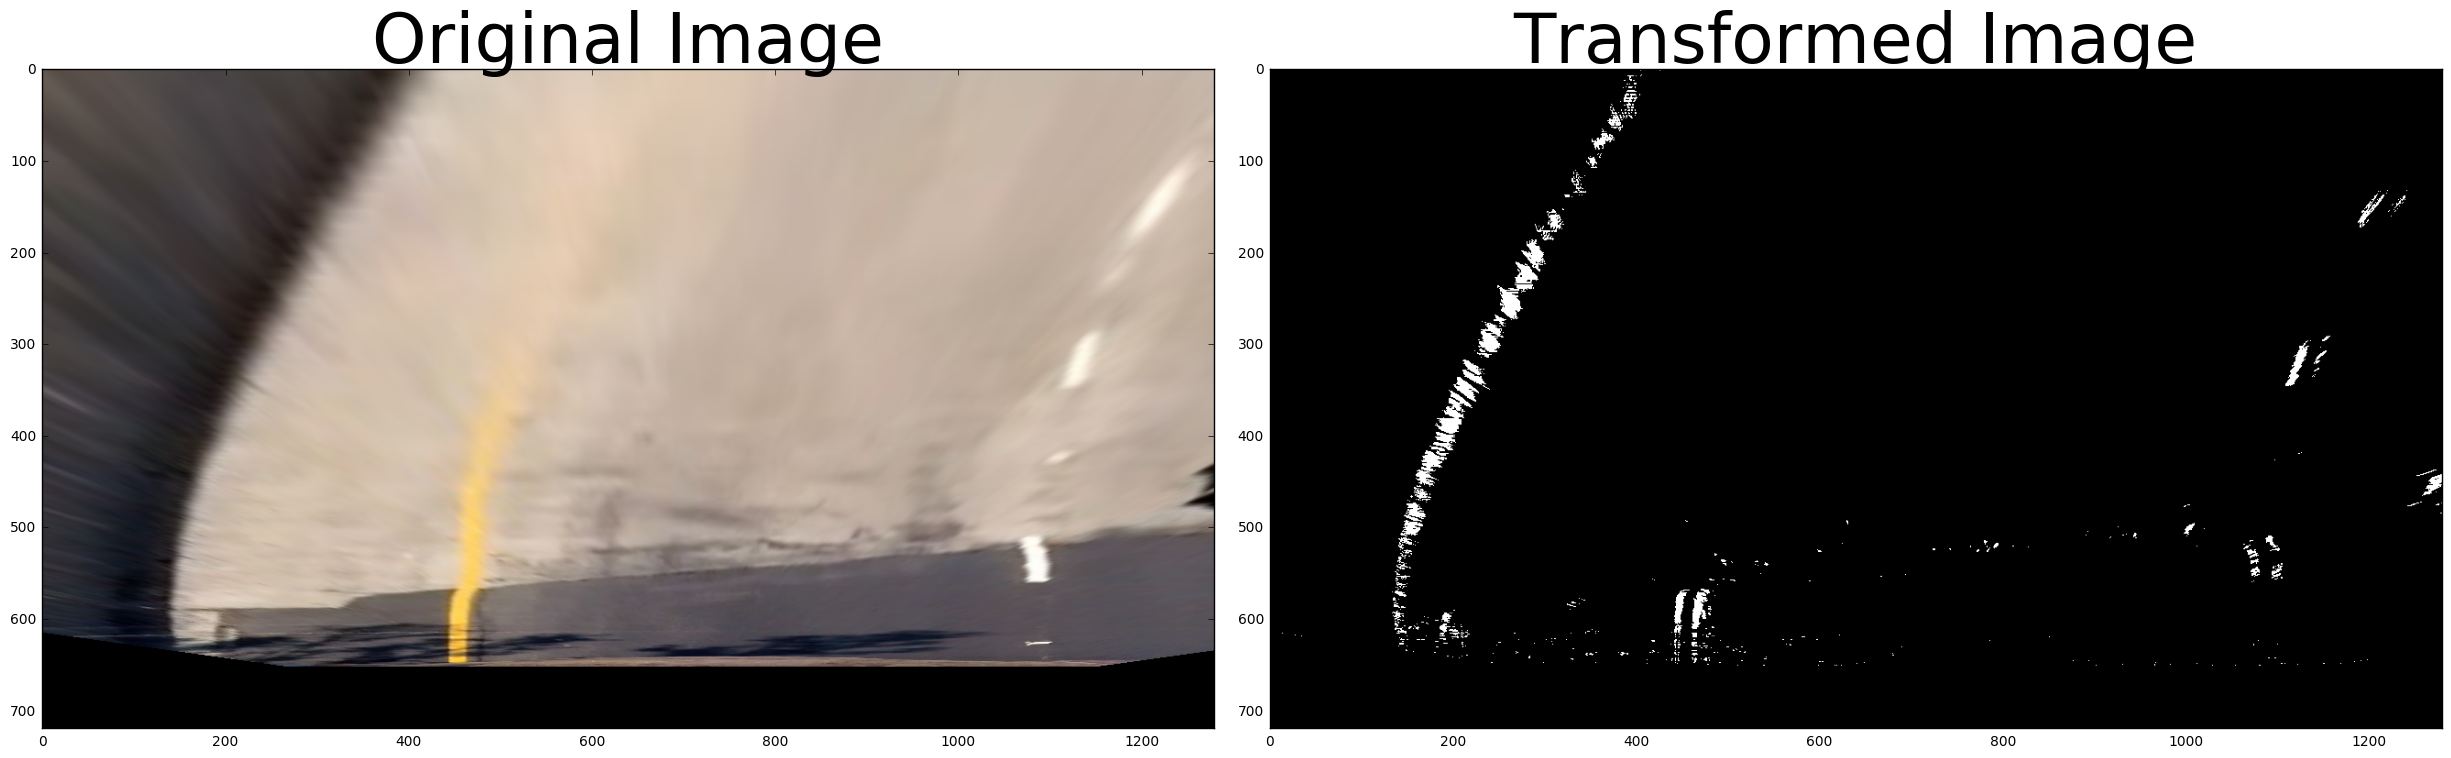

In [398]:
interact(hls_sobel_combination,
         mag_low=widgets.IntSlider(min=0,max=255,step=5,value=30), mag_high=widgets.IntSlider(min=0,max=255,step=5,value=190),
         dir_low=widgets.FloatSlider(min=0.0,max=3.2,step=0.1,value=0.0),dir_high=widgets.FloatSlider(min=0.0,max=3.2,step=0.1,value=0.7),
         hls_low=widgets.IntSlider(min=0,max=255,step=5,value=0), hls_high=widgets.IntSlider(min=0,max=255,step=5,value=250),
        );

### Calculate Curvation

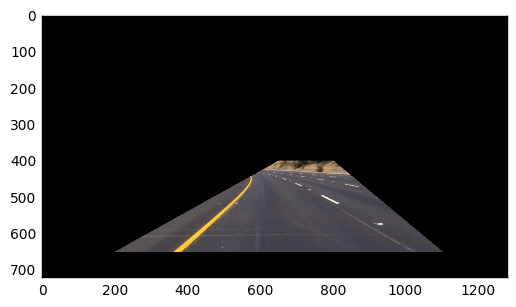

In [218]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

vertices = np.array([[(200, 650),(1100, 650),(800,400),(650, 400)]], dtype=np.int32)
test_img = mpimg.imread('test_images/test2.jpg')
test_img = undistort_image(test_img)
test_img = region_of_interest(test_img,vertices)
#test_img = perspective_transform(test_img)

plt.imshow(test_img)

In [ ]:
def pipeline(color_image):
    color_image = undistort_image(color_image)
    #perspective = perspective_transform(color_image)
    #gray = cv2.cvtColor(perspective, cv2.COLOR_RGB2GRAY)
    sobel = sobel_image(color_image)
    scaled_sobel = np.uint8(sobel * 255./np.max(sobel))
    perspective = perspective_transform(scaled_sobel)
    vertices = np.array([[(350, 600),(1200, 600),(1200,200),(350, 200)]], dtype=np.int32)
    roi = region_of_interest(perspective, vertices)
    gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    m = np.zeros_like(gray)
    m[gray>0] = 1
    return m

test_img = mpimg.imread('test_images/test4.jpg')
cool = pipeline(test_img)
show_two_images(test_img, cool)

In [444]:
def find_curve_function(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)

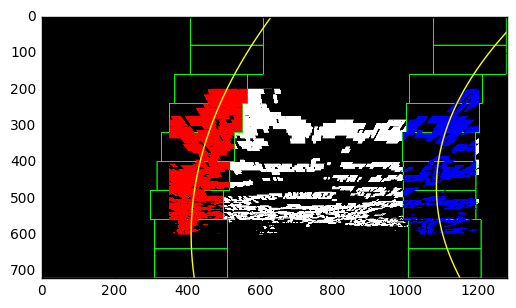

In [443]:
test_img = mpimg.imread('test_images/test5.jpg')
cool = pipeline(test_img)
# plt.imshow(cool)
find_curve_function(cool)
# plt.imshow(cool)
#plt.imshow(combined)

In [382]:
def drawback_on_road(image, warped, left_fitx, right_fitx, ploty, Minv, undist):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result
    #plt.imshow(result)

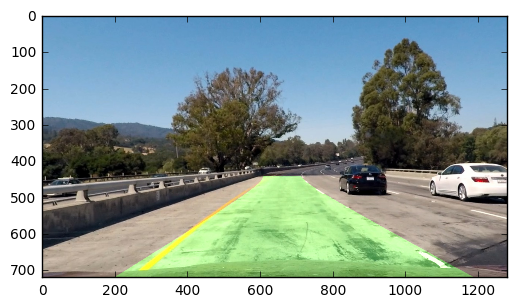

In [433]:
im = mpimg.imread('test_images/test1.jpg')
undist = undistort_image(im)
cool = pipeline(undist)
left, right, y = find_curve_function(cool)
imgg = drawback_on_road(im, cool, left, right, y, Minv, undist)
plt.imshow(imgg)

In [378]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [430]:
def process_image(image):
    undist = undistort_image(image)
    cool = pipeline(undist)
    left, right, y = find_curve_function(cool)
    result = drawback_on_road(im, cool, left, right, y, Minv, undist)
    return result

In [445]:
proj_output = 'project_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
proj_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time proj_clip.write_videofile(proj_output, audio=False)

[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


100%|█████████▉| 1260/1261 [11:53<00:00,  1.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 

CPU times: user 9min 28s, sys: 3min 26s, total: 12min 54s
Wall time: 11min 54s


In [446]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_output))